<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# removing non-residential property
house = house[house['MSZoning'].isin(['FV','RH','RL','RP','RM'])]

In [5]:
#house.info()

In [6]:
#drop columns w many null values
house.drop(['Alley','FireplaceQu','PoolQC','Fence','MiscFeature'],axis=1,inplace=True)

In [7]:
X = house.drop(['Id','SalePrice'],axis=1)
y = house['SalePrice']

In [8]:
X.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF'

In [9]:
#dropping non-fixed features
X.drop(['OverallQual', 'OverallCond','RoofStyle','RoofMatl', 'Exterior1st', 'Exterior2nd',\
'MasVnrType', 'MasVnrArea','ExterQual', 'ExterCond', 'BsmtCond', 'BsmtExposure',\
'BsmtFinType1', 'BsmtFinType2', 'BsmtUnfSF','Heating', 'HeatingQC','CentralAir',\
'Electrical', 'KitchenQual','Functional','GarageFinish','GarageQual', 'GarageCond',\
'PavedDrive','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch','ScreenPorch', \
'PoolArea', 'MiscVal','MoSold', 'YrSold','SaleType','SaleCondition'],axis=1,inplace=True)

In [10]:
X.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'YearBuilt', 'YearRemodAdd', 'Foundation', 'BsmtQual', 'BsmtFinSF1',
       'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea'],
      dtype='object')

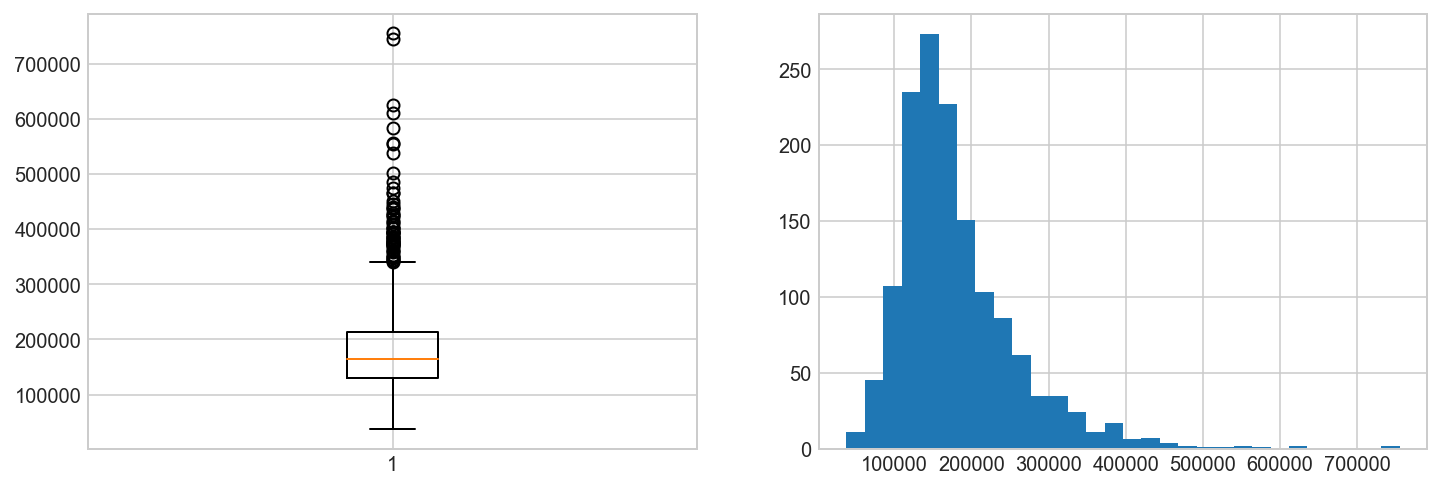

In [11]:
#Basic EDA for target variable
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.boxplot(y)
plt.subplot(1, 2, 2)
plt.hist(y,bins=30)
plt.show()

In [12]:
print(y.min(),y.mean(),y.max())

37900 181654.94206896552 755000


In [13]:
#checking if any error in houses with high saleprice
house[house['SalePrice'] > 600000].transpose()

,691,898,1169,1182
Id,692,899,1170,1183
MSSubClass,60,20,60,60
MSZoning,RL,RL,RL,RL
LotFrontage,104,100,118,160
LotArea,21535,12919,35760,15623
Street,Pave,Pave,Pave,Pave
LotShape,IR1,IR1,IR1,IR1
LandContour,Lvl,Lvl,Lvl,Lvl
Utilities,AllPub,AllPub,AllPub,AllPub
LotConfig,Corner,Inside,CulDSac,Corner


** <font color='purple'> target variable seems fine.. </font> **

In [14]:
X.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'YearBuilt', 'YearRemodAdd', 'Foundation', 'BsmtQual', 'BsmtFinSF1',
       'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea'],
      dtype='object')

In [15]:
#X.info()

In [16]:
#segregate by continuous vs categorical features
quant_features = X.select_dtypes(exclude='object').drop('MSSubClass',axis=1)

In [17]:
quant_features.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea
0,65.0,8450,2003,2003,706,0,856,856,854,0,...,0,2,1,3,1,8,0,2003.0,2,548
1,80.0,9600,1976,1976,978,0,1262,1262,0,0,...,1,2,0,3,1,6,1,1976.0,2,460
2,68.0,11250,2001,2002,486,0,920,920,866,0,...,0,2,1,3,1,6,1,2001.0,2,608
3,60.0,9550,1915,1970,216,0,756,961,756,0,...,0,1,0,3,1,7,1,1998.0,3,642
4,84.0,14260,2000,2000,655,0,1145,1145,1053,0,...,0,2,1,4,1,9,1,2000.0,3,836


In [19]:
cat_features = X[X.columns[~X.columns.isin(quant_features.columns)]]

In [20]:
cat_features.head()

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,Foundation,BsmtQual,GarageType
0,60,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,PConc,Gd,Attchd
1,20,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,CBlock,Gd,Attchd
2,60,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,PConc,Gd,Attchd
3,70,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,BrkTil,TA,Detchd
4,60,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,PConc,Gd,Attchd


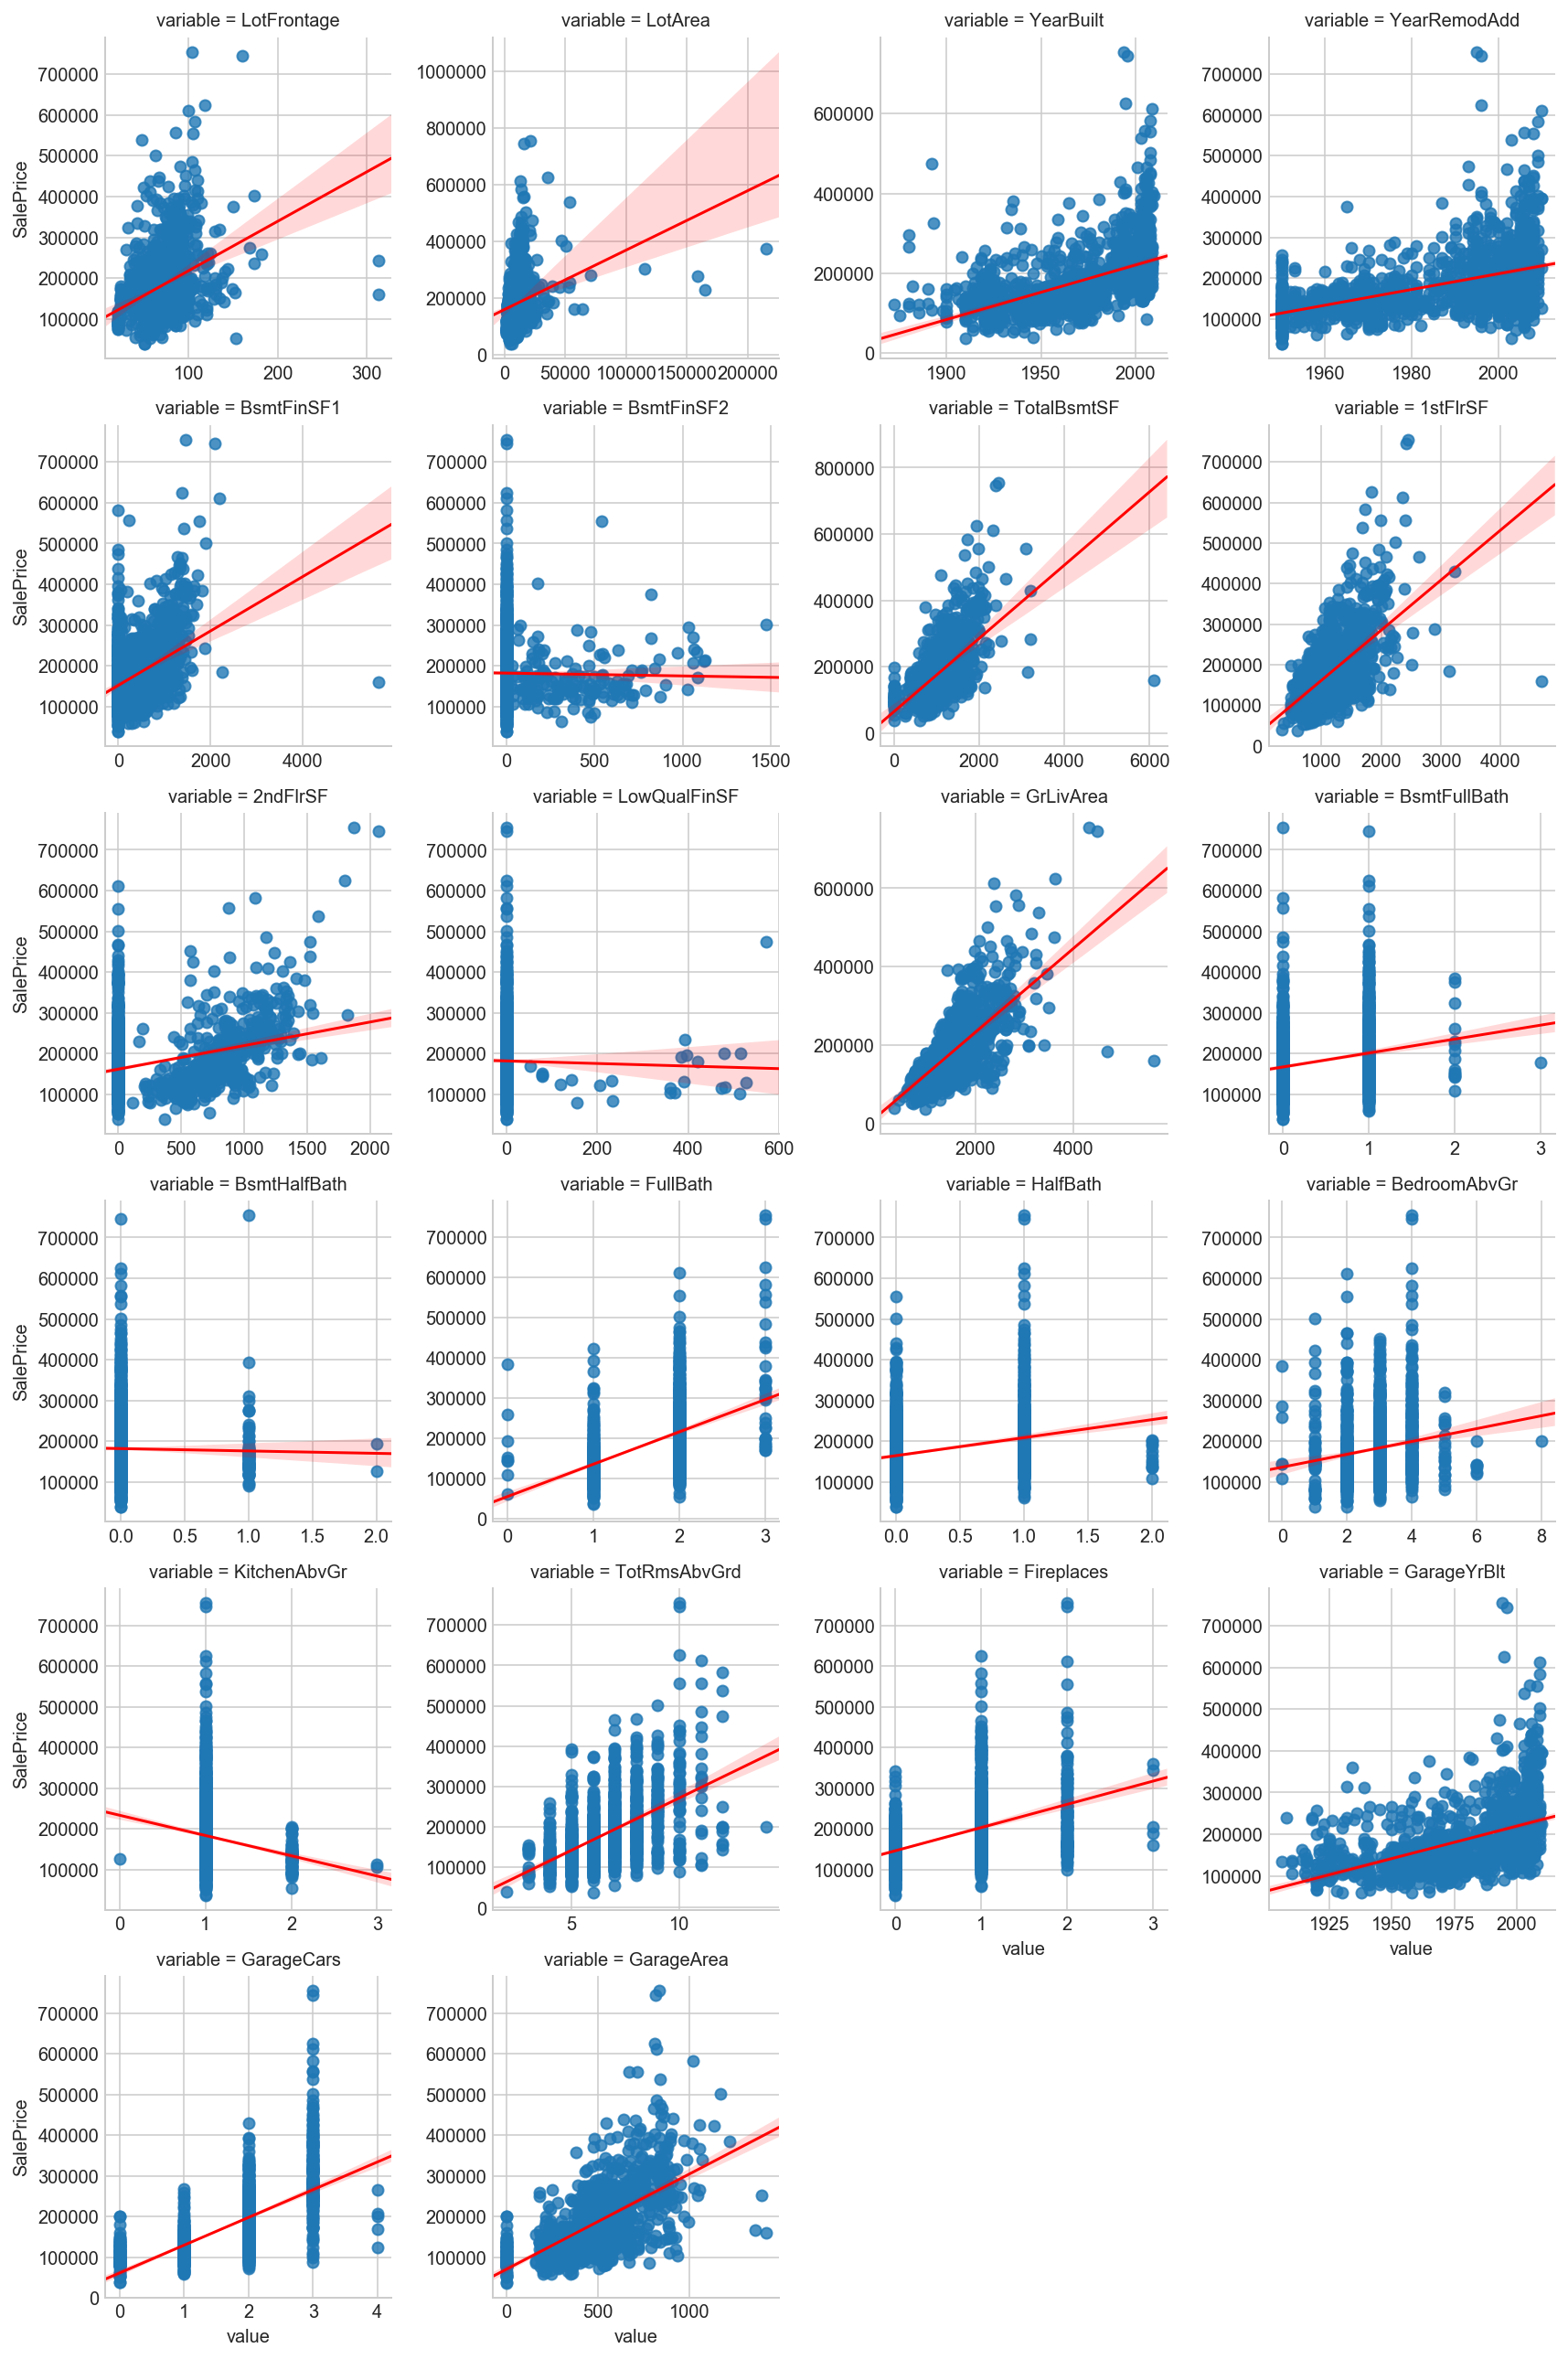

In [22]:
#bi-variate EDA
quant_plot = pd.melt(quant_features.join(y),id_vars='SalePrice')
g = sns.FacetGrid(quant_plot, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.regplot, 'value','SalePrice', line_kws={'color':'red','linewidth':1.5})

<font color='purple'> 
    - Some plots (e.g. TotalBsmtSF, 1stFlrSF) look more y=x*2/exp(x) then y=x : to KIV for subsequent model tuning
    <br>- Some outliers for SF-related features (e.g LotFrontage, LotArea, BsmtFinSF1, 1stFlrSF) : also KIV first</font> 

<br>  

/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


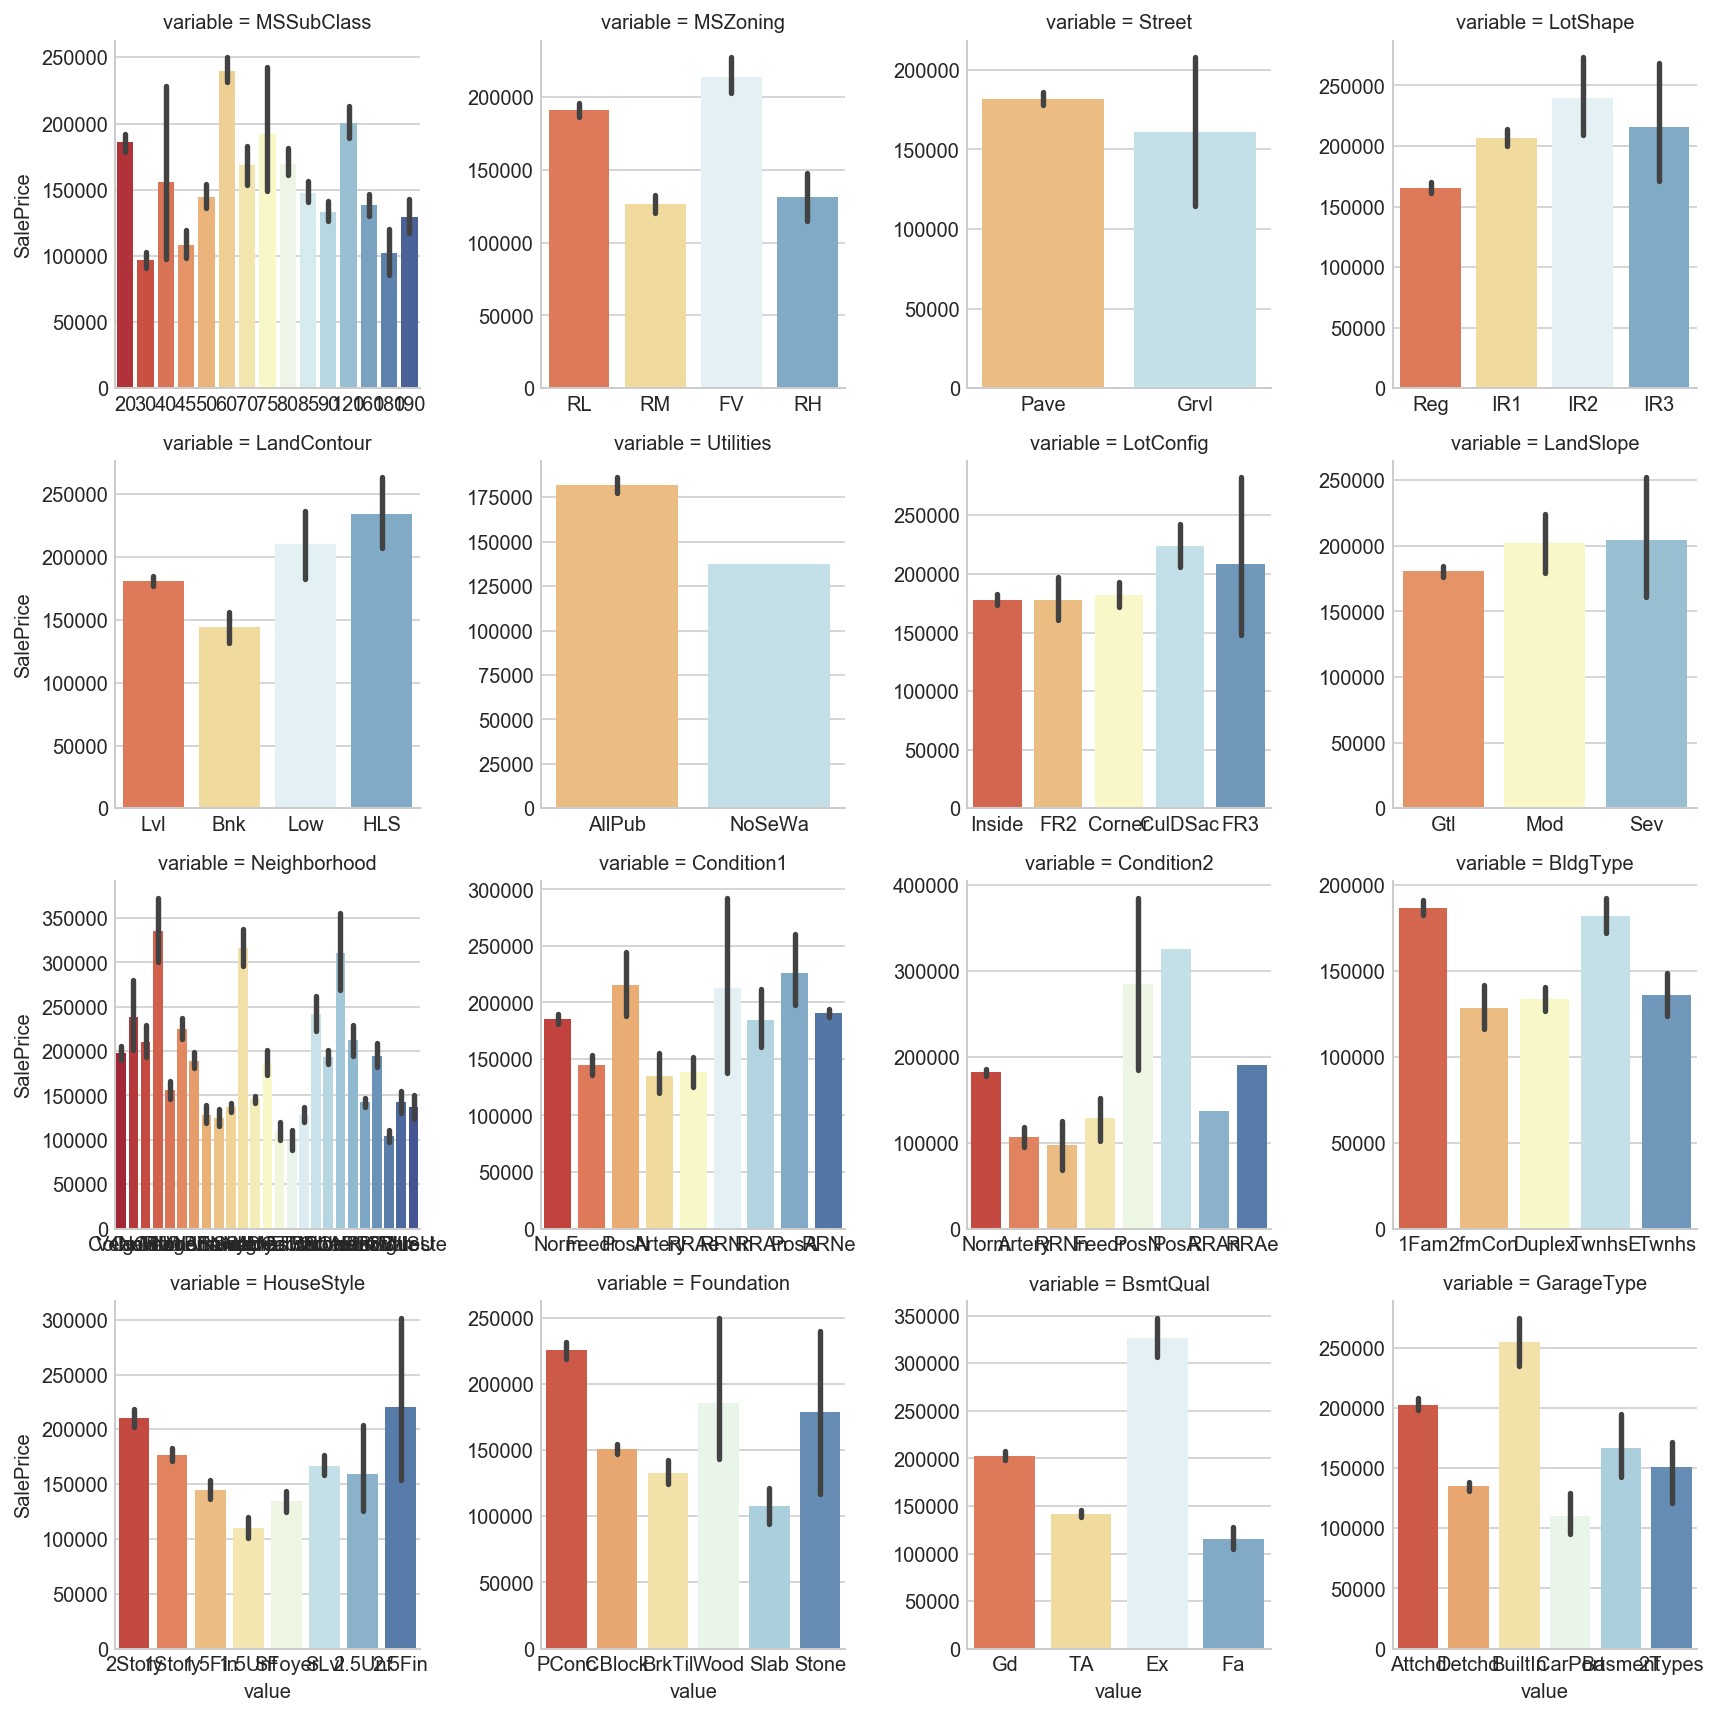

In [23]:
cat_plot = pd.melt(cat_features.join(y),id_vars='SalePrice')
g = sns.FacetGrid(cat_plot, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.barplot, 'value','SalePrice', palette='RdYlBu')

In [92]:
#sns.barplot(x='SalePrice',y='Neighborhood',data=house)

In [25]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, LassoCV, ElasticNetCV
from sklearn import metrics

In [26]:
#split data into train set to get values for imputation 
X_train = house[house['YrSold'] < 2010][X.columns]

# check columns that have null values
X_train.columns[X_train.isnull().apply(sum) > 0]

Index(['LotFrontage', 'BsmtQual', 'GarageType', 'GarageYrBlt'], dtype='object')

In [27]:
# get values (mean for quant features and mode for cat features)
d = {}
d['LotFrontage'] = X_train['LotFrontage'].mean()
d['GarageYrBlt'] = round(X_train['GarageYrBlt'].mean(),0)
d['GarageType'] = X_train['GarageType'].mode()[0]
d['BsmtQual'] = X_train['BsmtQual'].mode()[0]

In [28]:
#creating an extra column to indicate rows with imputed values
X_imp = X.copy()
X_imp['is_imputed'] = X_imp.isnull().apply(sum,axis=1) #can use max for 1/0

# imputing NA values
for feature in ['LotFrontage', 'BsmtQual', 'GarageType', 'GarageYrBlt']:
    X_imp[feature].fillna(d[feature],inplace=True)


In [29]:
#create dummies
X_imp['MSSubClass'] = X_imp['MSSubClass'].apply(lambda x: str(x))
X_imp = pd.get_dummies(X_imp,drop_first=True)

In [30]:
#split train and test data
X_train = X_imp[house['YrSold'] < 2010]
X_test = X_imp[house['YrSold'] >= 2010]
y_train = house[house['YrSold'] < 2010]['SalePrice']
y_test = house[house['YrSold'] >= 2010]['SalePrice']

In [31]:
X_train.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd
0,65.0,8450,2003,2003,706,0,856,856,854,0,...,0,0,0,1,0,1,0,0,0,0
1,80.0,9600,1976,1976,978,0,1262,1262,0,0,...,0,0,0,1,0,1,0,0,0,0
2,68.0,11250,2001,2002,486,0,920,920,866,0,...,0,0,0,1,0,1,0,0,0,0
3,60.0,9550,1915,1970,216,0,756,961,756,0,...,0,0,0,0,1,0,0,0,0,1
4,84.0,14260,2000,2000,655,0,1145,1145,1053,0,...,0,0,0,1,0,1,0,0,0,0


In [32]:
#scale data
scaler = StandardScaler()
scaler.fit(X_train)
sX_train = scaler.transform(X_train)
sX_test = scaler.transform(X_test)

In [33]:
lm = LinearRegression()

In [34]:
scores = cross_val_score(lm, sX_train, y_train, cv=3)
print(scores)
print(np.mean(scores), np.std(scores)) 

[-3.83742788e+13 -8.16725906e+23 -1.56828069e+24]
-7.950021975947915e+23 6.404321551492033e+23


In [35]:
scores = cross_val_score(lm, X_train, y_train, cv=3)
print(scores)
print(np.mean(scores), np.std(scores)) 

[0.83651856 0.81270448 0.69385688]
0.7810266403340901 0.062400335043824424


In [36]:
lm_model = lm.fit(X_train,y_train)
y_pred = lm_model.predict(X_test)
metrics.mean_squared_error(y_pred, y_test)

842647066.0202891

In [37]:
lm_coefs = pd.DataFrame({'variable':X_train.columns, 'coef':lm_model.coef_, 'abs_coef':np.abs(lm_model.coef_)})
lm_coefs.sort_values('abs_coef', inplace=True, ascending=False)
lm_coefs.head(10)

,variable,coef,abs_coef
89,Condition2_PosN,-140822.242336,140822.242336
88,Condition2_PosA,94099.102959,94099.102959
75,Neighborhood_StoneBr,54002.376334,54002.376334
68,Neighborhood_NoRidge,52396.639101,52396.639101
47,Utilities_NoSeWa,-46930.258824,46930.258824
110,BsmtQual_Gd,-45590.802323,45590.802323
69,Neighborhood_NridgHt,45523.923213,45523.923213
109,BsmtQual_Fa,-43210.553436,43210.553436
111,BsmtQual_TA,-42602.530780,42602.530780
42,LotShape_IR3,-39773.345914,39773.345914


In [38]:
#try lasso
opt_lasso = LassoCV(n_alphas=100, cv=3)
opt_lasso.fit(sX_train, y_train)

lasso = Lasso(alpha=opt_lasso.alpha_)
scores = cross_val_score(lasso, sX_train, y_train, cv=3)
print(scores)
print(np.mean(scores), np.std(scores))

[0.84611054 0.81270906 0.70605855]
0.7882927160879195 0.059725808507368486


In [40]:
lasso.fit(sX_train,y_train)
y_pred = lasso.predict(sX_test)
metrics.mean_squared_error(y_pred, y_test)

844345546.1292564

<font color='purple'> 
    - Lasso performs slightly better than LinearRegression
    </font> 
  
  <br>  

In [41]:
lasso.fit(sX_train, y_train)
lasso_coefs = pd.DataFrame({'variable':X_train.columns, 'coef':lasso.coef_, 'abs_coef':np.abs(lasso.coef_)})
lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)
lasso_coefs.head()

,variable,coef,abs_coef
10,GrLivArea,29374.311760,29374.311760
110,BsmtQual_Gd,-19897.261796,19897.261796
111,BsmtQual_TA,-19875.206472,19875.206472
69,Neighborhood_NridgHt,11460.769194,11460.769194
68,Neighborhood_NoRidge,9701.504545,9701.504545


In [42]:
l1_ratios = np.linspace(0.01, 1.0, 25) 
opt_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=3)
opt_enet.fit(sX_train, y_train)

enet = ElasticNet(alpha=opt_enet.alpha_, l1_ratio=opt_enet.l1_ratio_)
scores = cross_val_score(enet, sX_train, y_train, cv=3)
print(scores)
print(np.mean(scores), np.std(scores))

[0.84611054 0.81270906 0.70605855]
0.7882927160879195 0.059725808507368486


<font color='purple'> 
    - ElasticNet and Lasso similar output (i.e. opt_enet.l1_ratio_ = 1.0)
    </font> 
  
  <br>  

**Further feature engineering and try to improve model**

In [43]:
best_features = list(lasso_coefs.head(20)['variable'])

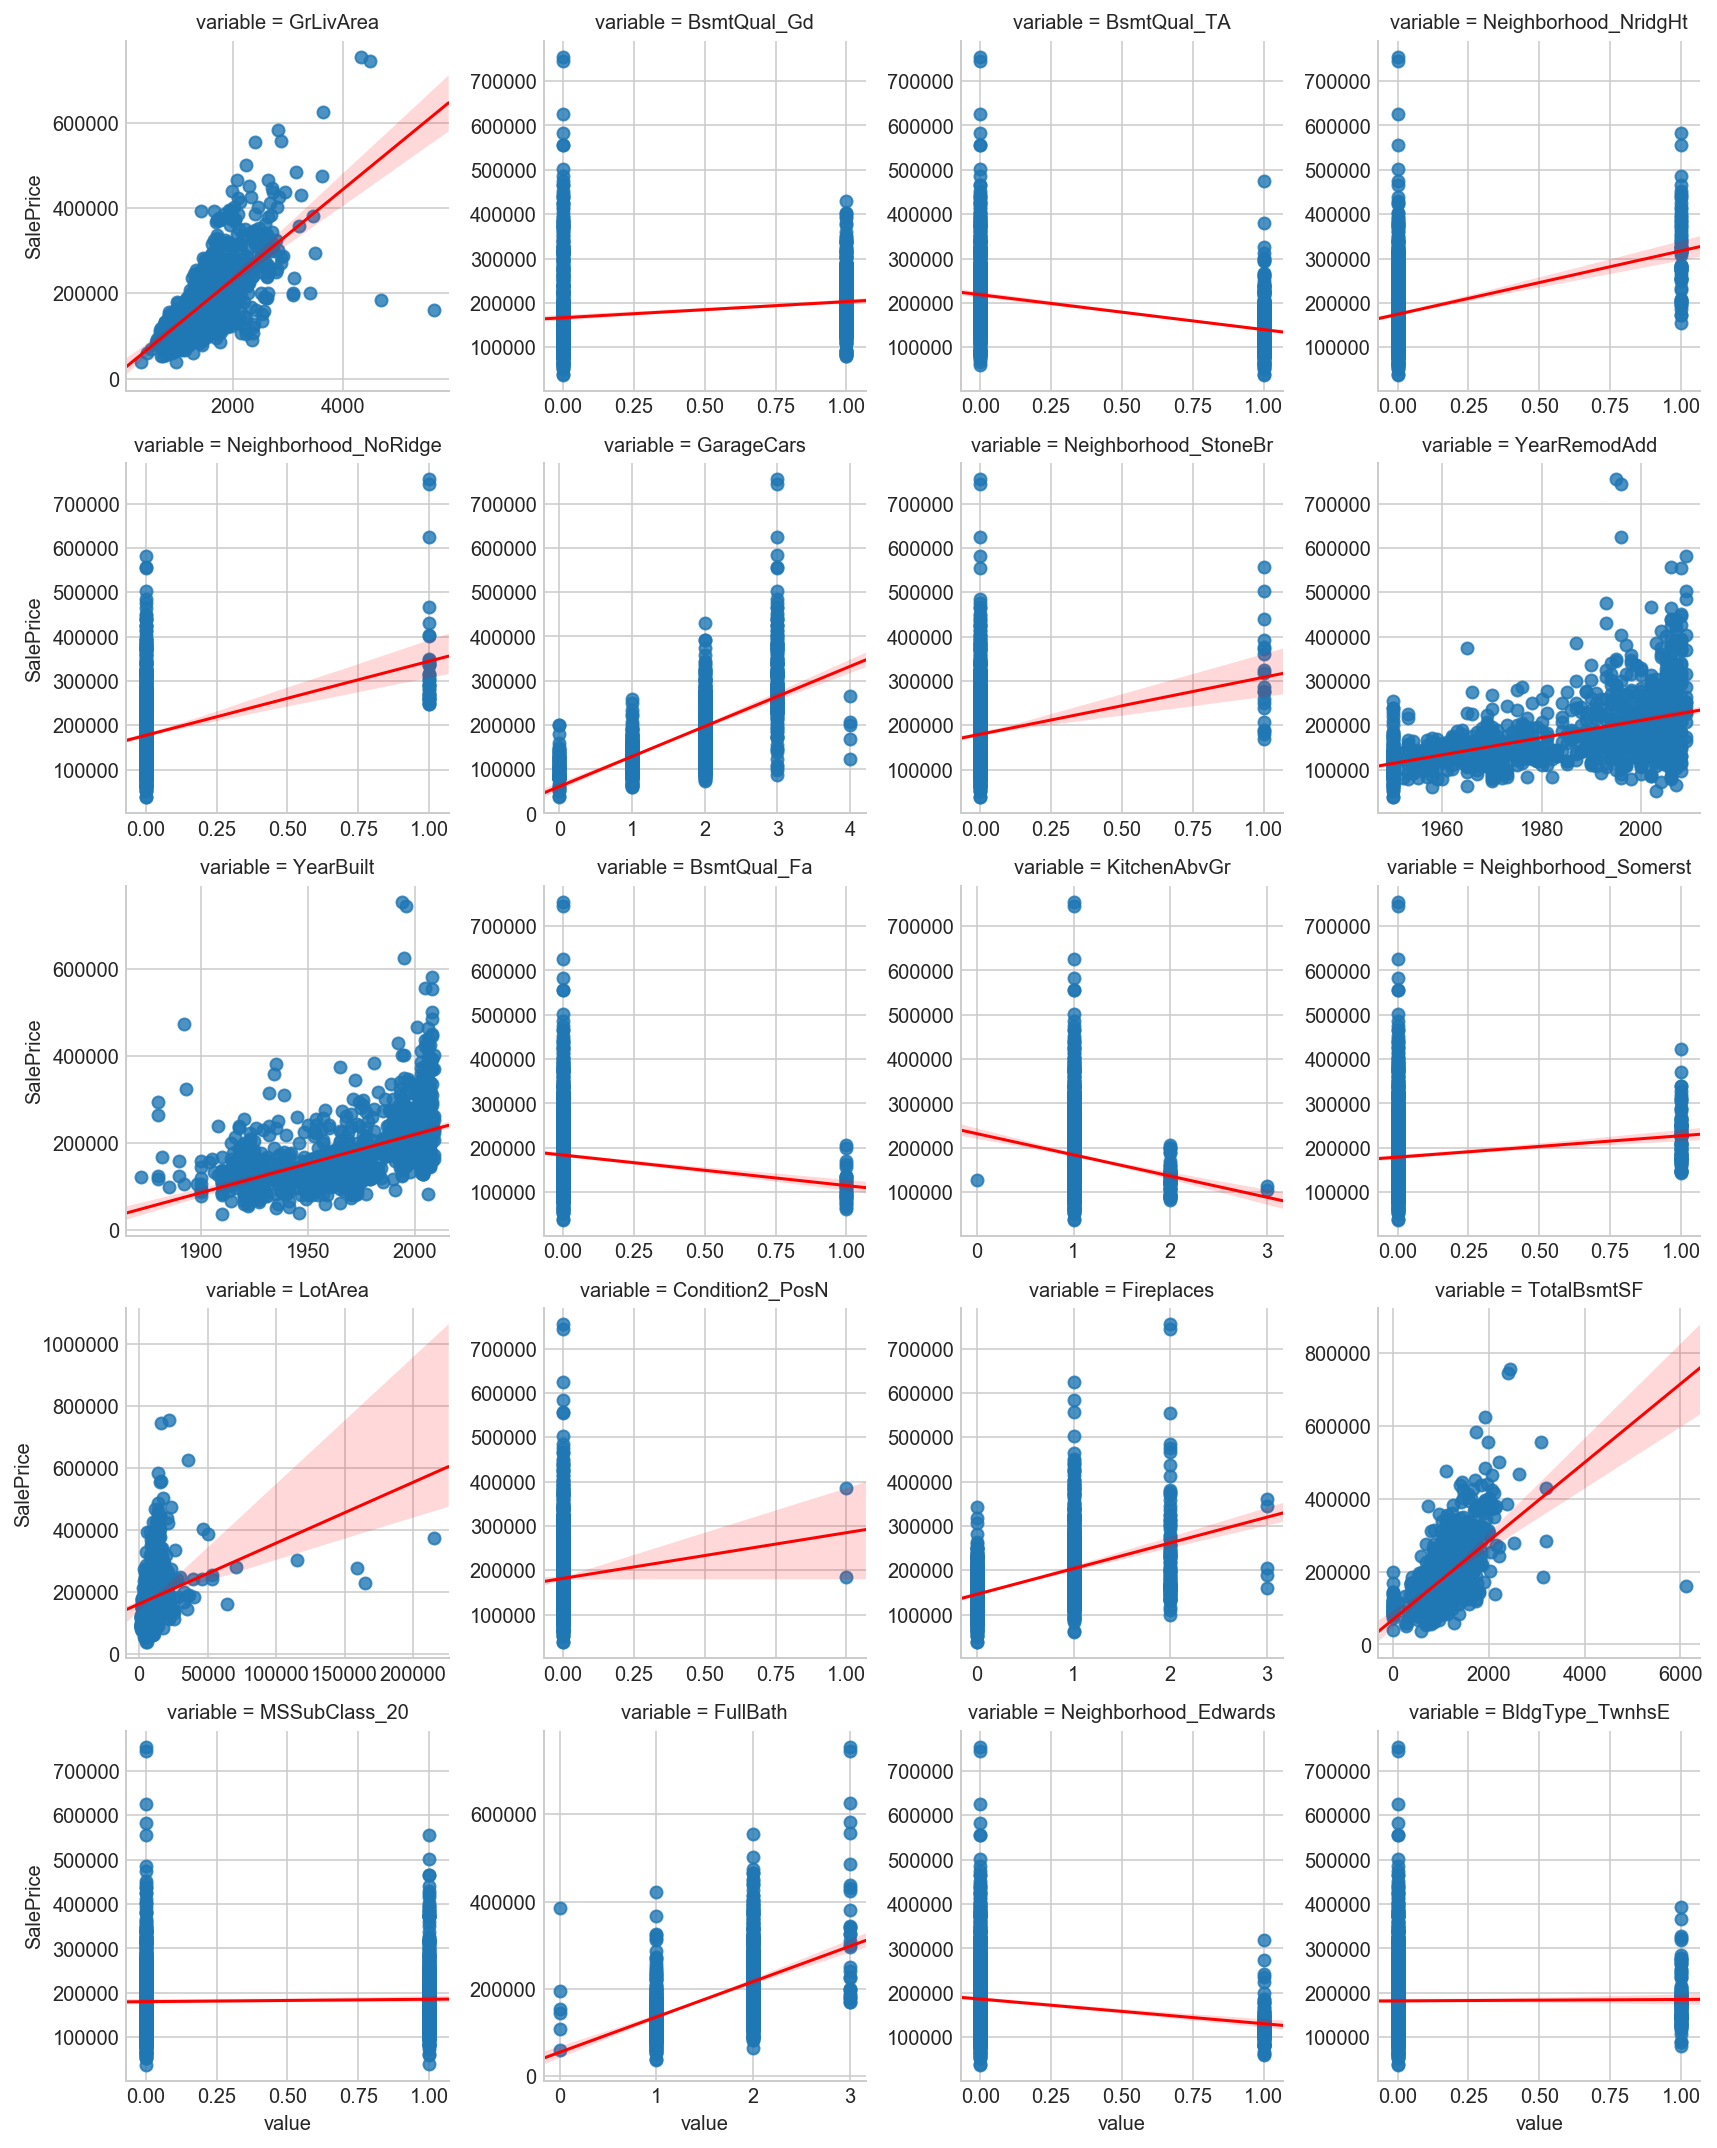

In [44]:
quant_plot = pd.melt(X_train[best_features].join(y),id_vars='SalePrice')
g = sns.FacetGrid(quant_plot, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.regplot, 'value','SalePrice', line_kws={'color':'red','linewidth':1.5})

In [45]:
# drop outliers
house.drop(house[house['GrLivArea'] > 4500].index,inplace=True)
# from shape of scatterplot, log GrLivArea
house['GrLivArea'] = np.log(house['GrLivArea'])

In [46]:
house['TotalSF'] = house['TotalBsmtSF'] + house['1stFlrSF'] + house['2ndFlrSF']
house.drop(['TotalBsmtSF','1stFlrSF','2ndFlrSF'],axis=1,inplace=True)

In [47]:
# Repeat all previous steps...

X = house.drop(['Id','SalePrice'],axis=1)
y = house['SalePrice']

#dropping non-fixed features
X.drop(['OverallQual', 'OverallCond','RoofStyle','RoofMatl', 'Exterior1st', 'Exterior2nd',\
'MasVnrType', 'MasVnrArea','ExterQual', 'ExterCond', 'BsmtCond', 'BsmtExposure',\
'BsmtFinType1', 'BsmtFinType2', 'BsmtUnfSF','Heating', 'HeatingQC','CentralAir',\
'Electrical', 'KitchenQual','Functional','GarageFinish','GarageQual', 'GarageCond',\
'PavedDrive','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch','ScreenPorch', \
'PoolArea', 'MiscVal','MoSold', 'YrSold','SaleType','SaleCondition'],axis=1,inplace=True)

#split data into train set to get values for imputation 
X_train = house[house['YrSold'] < 2010][X.columns]

# check columns that have null values
X_train.columns[X_train.isnull().apply(sum) > 0]

# get values (mean for quant features and mode for cat features)
d = {}
d['LotFrontage'] = X_train['LotFrontage'].mean()
d['GarageYrBlt'] = round(X_train['GarageYrBlt'].mean(),0)
d['GarageType'] = X_train['GarageType'].mode()[0]
d['BsmtQual'] = X_train['BsmtQual'].mode()[0]

#creating an extra column to indicate rows with imputed values
X_imp = X.copy()
X_imp['is_imputed'] = X_imp.isnull().apply(sum,axis=1) 

# imputing NA values
for feature in ['LotFrontage', 'BsmtQual', 'GarageType', 'GarageYrBlt']:
    X_imp[feature].fillna(d[feature],inplace=True)

#create dummies
X_imp['MSSubClass'] = X_imp['MSSubClass'].apply(lambda x: str(x))
X_imp = pd.get_dummies(X_imp,drop_first=True)

#split train and test data
X_train = X_imp[house['YrSold'] < 2010]
X_test = X_imp[house['YrSold'] >= 2010]
y_train = house[house['YrSold'] < 2010]['SalePrice']
y_test = house[house['YrSold'] >= 2010]['SalePrice']

#scale data
scaler = StandardScaler()
scaler.fit(X_train)
sX_train = scaler.transform(X_train)
sX_test = scaler.transform(X_test)

In [48]:
opt_lasso = LassoCV(n_alphas=100, cv=3)
opt_lasso.fit(sX_train, y_train)

lasso = Lasso(alpha=opt_lasso.alpha_)
scores = cross_val_score(lasso, sX_train, y_train, cv=3)
print(scores)
print(np.mean(scores), np.std(scores))

[0.87839233 0.85682217 0.84786289]
0.8610257972201548 0.012813134861943635


In [49]:
lasso.fit(sX_train,y_train)
y_pred = lasso.predict(sX_test)
metrics.mean_squared_error(y_pred, y_test)

763852151.7426822

In [50]:
coefs_vars = pd.DataFrame({'variable':X_train.columns, 'coef':lasso.coef_, 'abscoef':np.abs(lasso.coef_)})
coefs_vars.sort_values('abscoef', ascending=False, inplace=True)


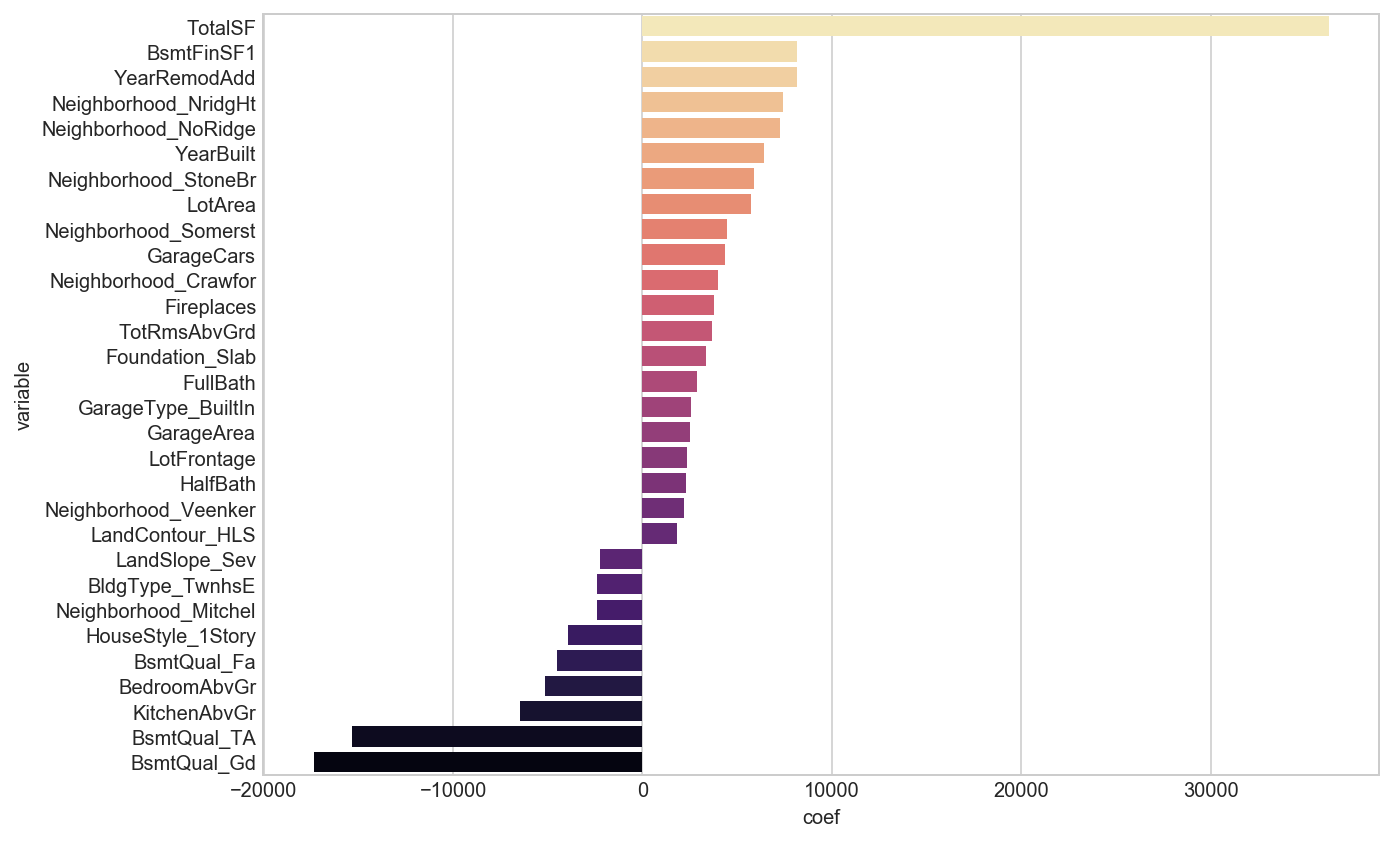

In [51]:
plt.figure(figsize=(10,7))
sns.barplot(y='variable',x='coef',data=coefs_vars[0:30].sort_values('coef',ascending=False), palette='magma_r')


<font color='purple'> 
    - Better performance after feature engineering
    </font> 
  
  <br>  

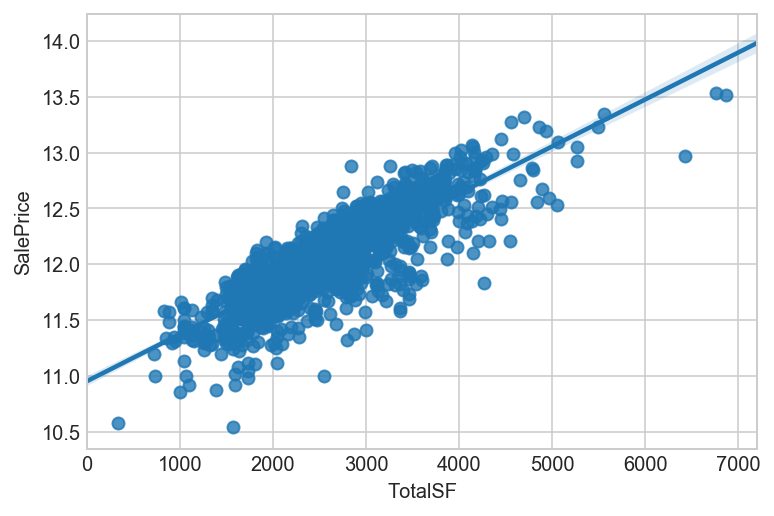

In [52]:
sns.regplot(house['TotalSF'],np.log(house['SalePrice']))

In [53]:
#tested logging target variable based on above graph
y_train = np.log(house[house['YrSold'] < 2010]['SalePrice'])
y_test = np.log(house[house['YrSold'] >= 2010]['SalePrice'])

In [54]:
opt_lasso = LassoCV(n_alphas=100, cv=3)
opt_lasso.fit(sX_train, y_train)

lasso = Lasso(alpha=opt_lasso.alpha_)
scores = cross_val_score(lasso, sX_train, y_train, cv=3)
print(scores)
print(np.mean(scores), np.std(scores))

[0.898688   0.8731405  0.87654581]
0.8827914369406575 0.011326210573627914


In [55]:
lasso.fit(sX_train,y_train)
y_pred = lasso.predict(sX_test)
metrics.mean_squared_error(np.exp(y_pred), np.exp(y_test))

568327876.3297704

<font color='purple'> 
    - Slight improvements
    </font> 
  

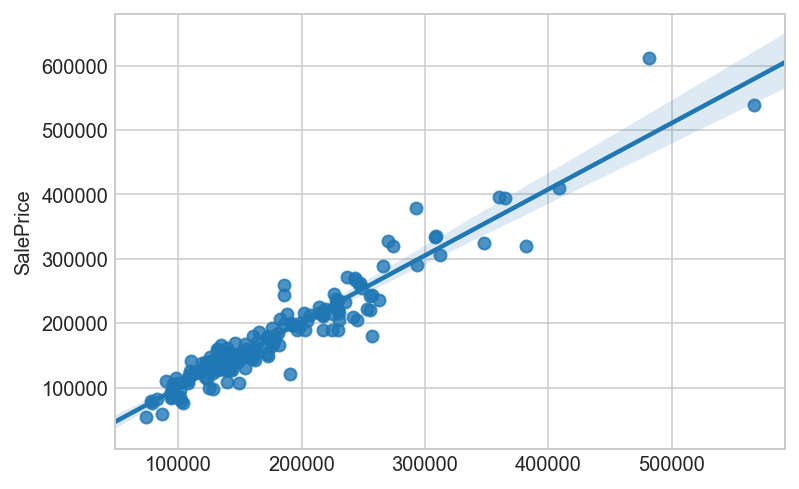

In [56]:
sns.regplot(np.exp(y_pred),np.exp(y_test))

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


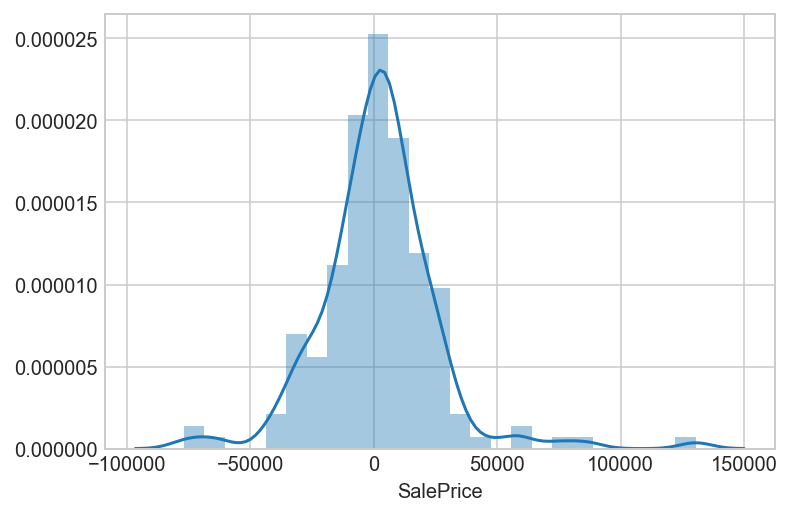

In [57]:
sns.distplot(np.exp(y_test)-np.exp(y_pred))

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [58]:
#predicting price for entire dataset
scaler.fit(X_train)
lasso.fit(sX_train,y_train)
y_pred = lasso.predict(scaler.transform(X_imp))

In [59]:
#defining target variable as residual (saleprice - prediction)
res_calc = pd.DataFrame(np.exp(y_pred), columns=['y_pred']).join(house['SalePrice'].reset_index(drop=True))
res_calc['res'] = res_calc['SalePrice'] - res_calc['y_pred']
y = res_calc['res']

In [60]:
#defining renovate-able features
reno = house.columns[~house.columns.isin(X.columns)]
reno = reno.drop(['Id','MoSold', 'YrSold', 'SaleType','SaleCondition', 'SalePrice'])
reno = house[reno]

In [61]:
reno.head()

,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,...,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,...,TA,TA,Y,0,61,0,0,0,0,0
1,6,8,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,...,TA,TA,Y,298,0,0,0,0,0,0
2,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,...,TA,TA,Y,0,42,0,0,0,0,0
3,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,...,TA,TA,Y,0,35,272,0,0,0,0
4,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,...,TA,TA,Y,192,84,0,0,0,0,0


In [62]:
reno.columns

Index(['OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtUnfSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [63]:
#reno_plot = pd.melt(reno.select_dtypes(exclude='object').join(y),id_vars='res')
#g = sns.FacetGrid(reno_plot, col='variable', col_wrap=4, sharex=False, sharey=False)
#g = g.map(sns.distplot, 'value')

In [64]:
#reno_plot = pd.melt(reno.select_dtypes(include='object'))
#g = sns.FacetGrid(reno_plot, col='variable', col_wrap=4, sharex=False, sharey=False)
#g = g.map(sns.countplot, 'value')

<font color='purple'> 
    - Large class inbalance observed in multiple features

    </font> 

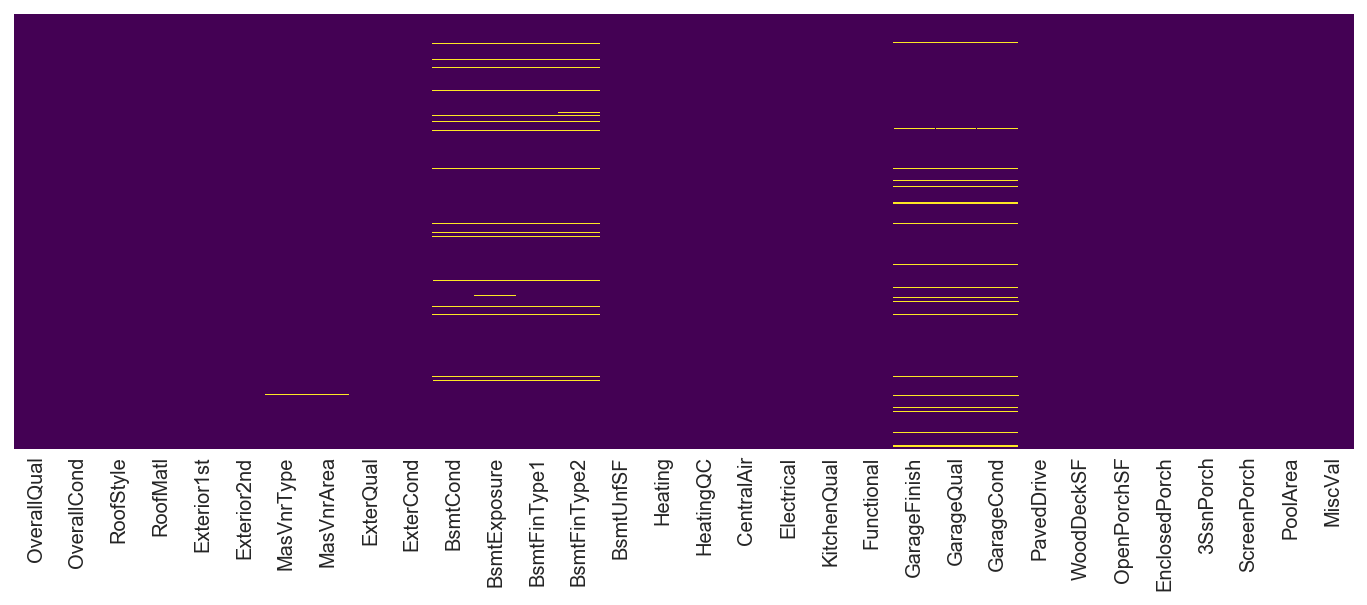

In [65]:
plt.figure(figsize=(12,4))
sns.heatmap(reno.isnull(),yticklabels=False,cbar=False,cmap='viridis') 

In [66]:
reno.columns[reno.isnull().apply(sum) > 0]

Index(['MasVnrType', 'MasVnrArea', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Electrical', 'GarageFinish', 'GarageQual',
       'GarageCond'],
      dtype='object')

In [67]:
#investigating null values

#reno[reno['BsmtCond'].isnull()].transpose()
#reno[reno['GarageQual'].isnull()].transpose()
#reno[reno['MasVnrArea'].isnull()]
house[reno['Electrical'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF
1379,1380,80,RL,73.0,9735,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,5,2008,WD,Normal,167500,1778


In [68]:
#creating an extra column to indicate rows with imputed values
reno_imp = reno.copy()
reno_imp['is_imputed'] = reno_imp.isnull().apply(sum,axis=1) 

In [69]:
#Assume that null values for Bsmt/Garage/MasVnr means houses don't have Bsmt/Garage/MasVnr

for feature in ['MasVnrType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',\
               'BsmtFinType2', 'GarageFinish', 'GarageQual','GarageCond']:
    reno_imp[feature].fillna('None',inplace=True)
    
reno_imp['MasVnrArea'].fillna(0, inplace=True)

In [70]:
# impute null electrical value with mode of 'train' set
house[house['YrSold'] < 2010 ]['Electrical'].value_counts()
reno_imp['Electrical'].fillna('SBrkr', inplace=True)

In [71]:
#check for any more null values 
reno_imp.isnull().any().any()

False

In [72]:
#check for misclassified/duplicated/weird feature categories
for feature in reno_imp.select_dtypes(include='object').columns:
    print (feature, reno_imp[feature].unique())

RoofStyle ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMatl ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll']
Exterior1st ['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock']
Exterior2nd ['VinylSd' 'MetalSd' 'Wd Shng' 'HdBoard' 'Plywood' 'Wd Sdng' 'CmentBd'
 'BrkFace' 'Stucco' 'AsbShng' 'Brk Cmn' 'ImStucc' 'AsphShn' 'Stone'
 'Other' 'CBlock']
MasVnrType ['BrkFace' 'None' 'Stone' 'BrkCmn']
ExterQual ['Gd' 'TA' 'Ex' 'Fa']
ExterCond ['TA' 'Gd' 'Fa' 'Po' 'Ex']
BsmtCond ['TA' 'Gd' 'None' 'Fa' 'Po']
BsmtExposure ['No' 'Gd' 'Mn' 'Av' 'None']
BsmtFinType1 ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'None' 'LwQ']
BsmtFinType2 ['Unf' 'BLQ' 'None' 'ALQ' 'Rec' 'LwQ' 'GLQ']
Heating ['GasA' 'GasW' 'Grav' 'Wall' 'OthW' 'Floor']
HeatingQC ['Ex' 'Gd' 'TA' 'Fa' 'Po']
CentralAir ['Y' 'N']
Electrical ['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix']
KitchenQual ['Gd' 'TA' 'Ex' 'Fa']
Functional ['Typ' 'Min1'

In [73]:
reno_imp['BsmtExposure'].value_counts()

No      947
Av      219
Gd      132
Mn      112
None     38
Name: BsmtExposure, dtype: int64

In [74]:
#create dummies
reno_imp = pd.get_dummies(reno_imp,drop_first=True)

In [75]:
#split train and test data
reno_train = reno_imp[house['YrSold'] < 2010]
reno_test = reno_imp[house['YrSold'] >= 2010]

In [76]:
# some indexing issue so join res_calc and house df tgt first, then split train and test set
res_calc.rename(columns={'SalePrice':'saleprice'},inplace=True)
temp = res_calc.join(house.reset_index())
res_train = temp[temp['YrSold'] < 2010]['res']
res_test = temp[temp['YrSold'] >= 2010]['res']

In [77]:
print(reno_train.shape, res_train.shape)
print(reno_test.shape, res_test.shape)

print(reno_train.isnull().any().any(), res_train.isnull().any())
print(reno_test.isnull().any().any(), res_test.isnull().any())

(1276, 120) (1276,)
(172, 120) (172,)
False False
False False


In [78]:
#scale data
scaler = StandardScaler()
scaler.fit(reno_train)
sreno_train = scaler.transform(reno_train)
sreno_test = scaler.transform(reno_test)

In [79]:
opti_lasso = LassoCV(n_alphas=100, cv=3)
opti_lasso.fit(sreno_train, res_train)

res_lasso = Lasso(alpha=opti_lasso.alpha_)
scores = cross_val_score(res_lasso, sreno_train, res_train, cv=3)
print(scores)
print(np.mean(scores), np.std(scores))

[0.17791329 0.19508647 0.15745871]
0.17681949077710427 0.01538092876168515


In [80]:
res_lasso.fit(sreno_train,res_train)
res_pred = res_lasso.predict(sreno_test)
metrics.mean_squared_error(res_pred, res_test)

484048207.1709284

<font color='purple'> 
    - Results are quite poor (i.e. renovate-able features cannot really explain variance from price remaining)

    </font> 


In [81]:
coefs_vars = pd.DataFrame({'variable':reno_train.columns, 'coef':res_lasso.coef_, 'abscoef':np.abs(res_lasso.coef_)})
coefs_vars.sort_values('abscoef', ascending=False, inplace=True)
coefs_vars.head()

,variable,coef,abscoef
0,OverallQual,5307.070873,5307.070873
1,OverallCond,5049.772432,5049.772432
22,RoofMatl_WdShngl,2604.151318,2604.151318
66,BsmtExposure_Gd,1954.095725,1954.095725
104,Functional_Typ,1565.578773,1565.578773


<font color='purple'> 
    - Tried to remove features with large class inbalance

    </font> 



In [82]:
drop = reno_train.columns[abs(reno_train.skew())>1]
reno_train2 = reno_train.drop(drop, axis=1)
reno_test2 = reno_test.drop(drop, axis=1)

In [83]:
print(reno_train2.shape, reno_test2.shape)

(1276, 19) (172, 19)


In [84]:
scaler = StandardScaler()
scaler.fit(reno_train2)
sreno_train2 = scaler.transform(reno_train2)
sreno_test2 = scaler.transform(reno_test2)

In [85]:
opti_lasso = LassoCV(n_alphas=100, cv=3)
opti_lasso.fit(sreno_train2, res_train)

res_lasso = Lasso(alpha=opti_lasso.alpha_)
scores = cross_val_score(res_lasso, sreno_train2, res_train, cv=3)
print(scores)
print(np.mean(scores), np.std(scores))

[0.18360557 0.17882316 0.21177813]
0.19140228572890436 0.014539578557305767


In [86]:
res_lasso.fit(sreno_train2,res_train)
res_pred = res_lasso.predict(sreno_test2)
metrics.mean_squared_error(res_pred, res_test)

498368559.5744191

In [87]:
coefs_vars = pd.DataFrame({'variable':reno_train2.columns, \
                           'coef':res_lasso.coef_, 'abscoef':np.abs(res_lasso.coef_)})
coefs_vars.sort_values('abscoef', ascending=False, inplace=True)
coefs_vars.head(10)

,variable,coef,abscoef
0,OverallQual,6901.831061,6901.831061
1,OverallCond,6033.003429,6033.003429
9,ExterQual_TA,-4244.289484,4244.289484
15,KitchenQual_Gd,-4113.511200,4113.511200
8,ExterQual_Gd,-3975.418857,3975.418857
11,BsmtExposure_No,-3023.083490,3023.083490
16,KitchenQual_TA,-2314.954878,2314.954878
18,GarageFinish_Unf,702.373322,702.373322
6,MasVnrType_BrkFace,-506.925152,506.925152
4,Exterior1st_VinylSd,-455.119262,455.119262


<font color='purple'> 
- R2 improved but MSE deproved -> not very effective

    </font> 




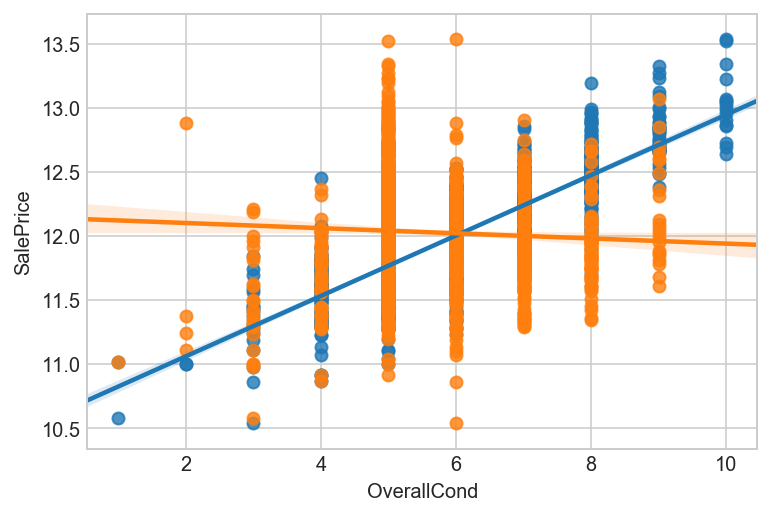

In [88]:
sns.regplot(house['OverallQual'], np.log(house['SalePrice']))
sns.regplot(house['OverallCond'], np.log(house['SalePrice']))

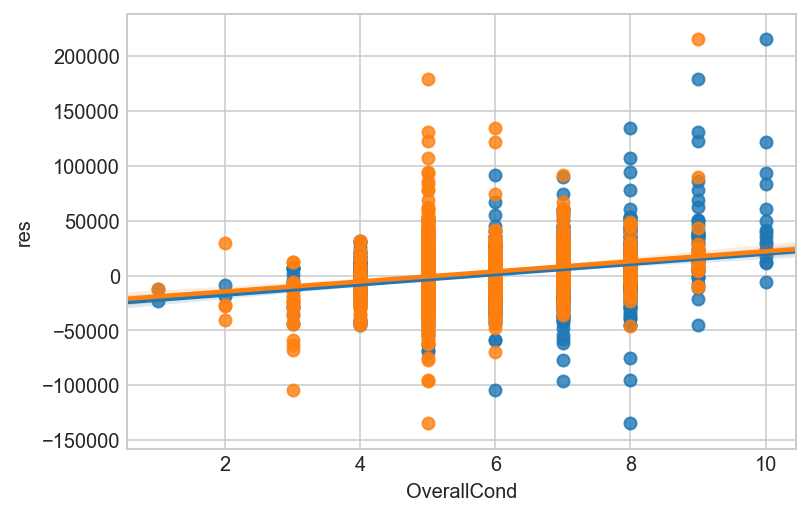

In [89]:
sns.regplot(house['OverallQual'], res_calc['res'])
sns.regplot(house['OverallCond'], res_calc['res'])

<font color='purple'> 
    - Overall, the model developed in qn 1 (using fixed features) performs well and can predict prices accurately
    <br>
    - The model developed in qn 2 is less successful and can only explain the variance in price remaining from the first model marginally. With that said, OverallQual and OverallCond stills remains good predictors of residual value. 

    </font> 



<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
import xgboost as xgb
from imblearn.over_sampling import SMOTE 

In [ ]:
house['SaleCondition'].value_counts()

In [ ]:
96/house.count().max()

In [ ]:
df = house.copy()
nfeatures = df.columns[df[df['SaleCondition'] == 'Abnorml'].isnull().any()]
nfeatures

In [ ]:
plt.figure(figsize=(10,3))
sns.heatmap(df[df['SaleCondition'] == 'Abnorml'].isnull()[nfeatures],yticklabels=False,cbar=False,cmap='viridis') 

In [ ]:
#Assume that null values for Bsmt/Garage/MasVnr means houses don't have Bsmt/Garage/MasVnr
for feature in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2',\
                'GarageType','GarageFinish','GarageQual', 'GarageCond']:
    df[feature].fillna('None',inplace=True)

df['GarageYrBlt'].fillna(-1,inplace=True)

In [ ]:
#Build Log Regression model first

In [ ]:
Random Over-Sampling
Cluster-Based Over Sampling (K-means clustering algorithm)
Informed Over Sampling: Synthetic Minority Over-sampling Technique (SMOTE)